In [1]:
sub_list = ['005','006','007','008','009','010','011','012','013','015','017','018','020','022','023','024']
task_list = ['localizer','imagine']
mask_list=['bilateral_hippo','bilateral_oc-temp']

In [2]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import numpy as np
import nibabel as nib
import nilearn
from nilearn.input_data import NiftiMasker,  MultiNiftiMasker
from nilearn.masking import intersect_masks
from nilearn import image
from nilearn import plotting
from nilearn.plotting import plot_roi
from scipy import stats
from sklearn import preprocessing
import matplotlib.pyplot as plt 
import scipy.io
#from mpi4py import MPI
import os
import pickle 
import time
from scipy.sparse import random
from scipy.stats import zscore
from scipy.spatial.distance import euclidean
from pathlib import Path
from shutil import copyfile
import seaborn as sns
import importlib
import csv

# Import machine learning libraries
import sklearn
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score, PredefinedSplit
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score

%matplotlib inline 
%autosave 5

Autosaving every 5 seconds


In [3]:
from platform import python_version
print('The python version is {}.'.format(python_version()))
print('The scikit-learn version is {}.'.format(sklearn.__version__))
print('The numpy version is {}.'.format(np.__version__))
print('The nilearn version is {}.'.format(nilearn.__version__))
print('The seaborn version is {}.'.format(sns.__version__))

The python version is 3.9.10.
The scikit-learn version is 1.0.2.
The numpy version is 1.20.3.
The nilearn version is 0.8.1.
The seaborn version is 0.11.2.


In [4]:
# Set printing precision
np.set_printoptions(precision=2, suppress=True)

# load some helper functions
sys.path.insert(0, '/jukebox/norman/karina/adderzip_fMRI/adderzip/code/mainanalysis')

#localizer
import adderzip_utils
from adderzip_utils import load_adderzip_stim_labels_localizer,load_adderzip_epi_data, shift_timing, label2TR, mask_data

importlib.reload(adderzip_utils)

# load some constants
from adderzip_utils import adderzip_dir, adderzip_bids_dir, adderzip_label_dict, n_runs, run_names, adderzip_TR, adderzip_hrf_lag, TRs_run

anat_dir=adderzip_bids_dir + 'derivatives/deface/'
out_dir= adderzip_bids_dir + 'derivatives/firstlevel/'
fmriprep_dir=adderzip_bids_dir + 'derivatives/fmriprep/'
data_dir='/jukebox/norman/karina/adderzip_fMRI/adderzip/data/mainanalysis/output'

task = task_list[0]
print('TASKS:', task)
print('LIST OF ALL TASKS:', run_names)
task_index = run_names.index(task)
print('task index:', task_index)
print('')

n_runs_localizer = n_runs[task_index]

TRs_run_localizer=170

print('ROIs = %s' % (mask_list))
print('Labels = %s' % (adderzip_label_dict))
print('number of runs = %d' % (n_runs_localizer))
print('number of participants = ',len(sub_list))
print('TRs per run after trimming = %s' % (TRs_run_localizer))

TASKS: localizer
LIST OF ALL TASKS: ['localizer']
task index: 0

ROIs = ['bilateral_hippo', 'bilateral_oc-temp']
Labels = {1: 'Faces', 2: 'Scenes', 3: 'Objects', 0: 'Rest'}
number of runs = 3
number of participants =  16
TRs per run after trimming = 170


In [5]:
#imagine
import adderzip_utils_imagine
from adderzip_utils_imagine import load_adderzip_stim_labels_imagine,load_adderzip_epi_data, shift_timing, label2TR, mask_data

# load some constants
from adderzip_utils_imagine import adderzip_dir, adderzip_bids_dir, adderzip_label_dict_imagine, adderzip_TR, adderzip_hrf_lag, run_names, run_order_start, n_runs, TRs_run

importlib.reload(adderzip_utils_imagine)

task = task_list[1]
print('TASK:', task)
print('LIST OF TASKS:', run_names)
task_index = run_names.index(task)
print('task index:', task_index)
print('')

n_runs_imagine = n_runs[task_index]

TRs_run_imagine=144
TRs_run_extra_imagine=216

trials_run_imagine = 32
trials_run_extra_imagine = 48

print('ROIs = %s' % (mask_list))
print('Labels = %s' % (adderzip_label_dict_imagine))
print('number of runs = %d' % (n_runs_imagine))
print('TRs per run after trimming = %s' % (TRs_run_imagine))
print('TRs per run after trimming = %s' % (TRs_run_extra_imagine))

TASK: imagine
LIST OF TASKS: ['imagine']
task index: 0

ROIs = ['bilateral_hippo', 'bilateral_oc-temp']
Labels = {0: 'Scenes', 1: 'Faces'}
number of runs = 2
TRs per run after trimming = 144
TRs per run after trimming = 216


In [6]:
def classifier(bold_train, labels_train, bold_test, labels_test, model,linReg):
    # normalize the data 
    scaler = StandardScaler()
    bold_train = scaler.fit_transform(bold_train)
    bold_test = scaler.fit_transform(bold_test)


    # Fit the model
    model.fit(bold_train, labels_train)

    # Compute your evaluation on the test set
    score = model.score(bold_test, labels_test)
    print('Accuracy = %s' % score)
    
    if linReg == 1:
        prediction = model.predict(bold_test)
        prediction_prob = model.predict_proba(bold_test)
    else:
        prediction = 'NA'
        prediction_prob = 'NA'
    
    return score, prediction, prediction_prob

model_linearSVC = LinearSVC(C=1)
model_linReg_1 = LogisticRegression(C=1.0, random_state=34, solver='liblinear')

In [7]:
def calc_auc(y_true,y_scores,makePlot): 
    fpr,tpr,threshold = roc_curve(y_true,y_scores,pos_label=1)

    roc_auc = auc(fpr,tpr)
    
    if makePlot == 1:
        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',
                lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        #title=' %s classifier for all 3 runs for %s subjects' % (classiType,partiNum)
        #plt.title(title)
        plt.legend(loc="lower right")
        plt.show()
    
    return roc_auc

In [8]:
def getLabel(this_sub,this_run,this_task): 
    
    label_dir = data_dir + '/label_list_%s/labels_run-0%i_%s.csv' % (this_task, this_run, this_sub)
    thisLabel = open(label_dir)
    thisLabel = csv.reader(thisLabel)
    thisLabel = list(thisLabel)
    thisLabel = np.array(thisLabel)
    thisLabel = np.float64(thisLabel)
    
    return thisLabel

def getBold(this_sub,this_run,this_task,this_mask):
    
    bold_dir = data_dir + '/bold_data_%s/%s/bold_run-0%i_%s.csv' % (this_task, this_mask, this_run, this_sub)
    thisBold = open(bold_dir)
    thisBold = csv.reader(thisBold)
    thisBold = list(thisBold)
    thisBold = np.array(thisBold)
    thisBold = np.float64(thisBold)
    
    return thisBold

def getGroup(this_sub,this_run):
    
    group_dir = data_dir + '/itemGroup_imagine/itemGroup_run-0%i_%s.csv' % (this_run, this_sub)
    group = open(group_dir)
    group = csv.reader(group)
    group = list(group)
    group = np.array(group)
    group = np.float64(group)
    #print('group')
    #print(group)
    
    return group
    
#     print('g+e')
#     print(group>=3)
    
#     newGr = np.zeros((len(group),2))
#     newGr[:,0] = group>=3
#     newGr[:,1] = group<=2
    
#     return newGr

In [9]:
def binarize(labels, category):
    
    find_zeros = np.where(labels[:] == 0)[0] #to double check that numbers line up
    find_ones = np.where(labels[:] == 1)[0] #to double check that numbers line up
    find_twos = np.where(labels[:] == 2)[0] #to double check that numbers line up
    find_threes = np.where(labels[:] == 3)[0] #to double check that numbers line up
    
    if category == 'faces':
        labels[find_ones] = 1
        labels[find_twos] = 0
        labels[find_threes] = 0
    if category == 'scenes':
        labels[find_ones] = 0
        labels[find_twos] = 1
        labels[find_threes] = 0
    if category == 'scenes':
        labels[find_ones] = 0
        labels[find_twos] = 0
        labels[find_threes] = 1
        
    return labels

005
Accuracy = 0.7


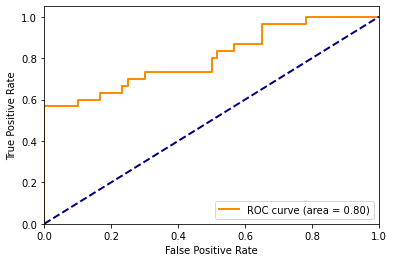

Accuracy = 0.8111111111111111
Accuracy = 0.8666666666666667
006
Accuracy = 0.9555555555555556
Accuracy = 0.8222222222222222
Accuracy = 0.9
007
Accuracy = 0.8111111111111111
Accuracy = 0.8555555555555555
Accuracy = 0.6888888888888889
008
Accuracy = 0.8222222222222222
Accuracy = 0.8111111111111111
Accuracy = 0.6111111111111112
009
Accuracy = 0.9222222222222223
Accuracy = 0.7222222222222222
Accuracy = 0.9333333333333333
010
Accuracy = 0.8888888888888888
Accuracy = 0.8
Accuracy = 0.9
011
Accuracy = 0.7444444444444445
Accuracy = 0.5555555555555556
Accuracy = 0.5888888888888889
012
Accuracy = 0.7333333333333333
Accuracy = 1.0
Accuracy = 0.8888888888888888
013
Accuracy = 0.7777777777777778
Accuracy = 0.8666666666666667
Accuracy = 0.9222222222222223
015
Accuracy = 0.8333333333333334
Accuracy = 0.8333333333333334
Accuracy = 0.7222222222222222
017
Accuracy = 0.8111111111111111
Accuracy = 0.7222222222222222
Accuracy = 0.8666666666666667
018
Accuracy = 0.9333333333333333
Accuracy = 0.8444444444444

In [26]:
#check classifier performance on localizer runs
#test on 2 and test out on held out third

folds = np.array([[10,11,12],[11,12,10],[12,10,11]])

for eachSubj in range(len(sub_list)):
    subNum = sub_list[eachSubj]
    print(subNum)
       
    for eachFold in range(3):
        
        trainRun_1 = folds[eachFold, 0]
        trainRun_2 = folds[eachFold, 1]
        
        trainBold_1 = getBold(subNum,trainRun_1,'localizer','bilateral_oc-temp')
        trainBold_2 = getBold(subNum,trainRun_2,'localizer','bilateral_oc-temp')
        
        trainBold = np.vstack((trainBold_1,trainBold_2))
        
        trainLabel_1 = getLabel(subNum,trainRun_1,'localizer')
        trainLabel_2 = getLabel(subNum,trainRun_2,'localizer')
        
        trainLabel = np.vstack((trainLabel_1,trainLabel_2))
        trainLabel = binarize(trainLabel,'faces')
        
        testRun = folds[eachFold, 2]
        
        testBold = getBold(subNum,testRun,'localizer','bilateral_oc-temp')
        
        testLabel = getLabel(subNum,testRun,'localizer')
        testLabel = binarize(testLabel,'faces')
        
        #print('trainBold',trainBold.shape)
        #print('trainLabel',trainLabel.shape)
        #print('testBold',testBold.shape)
        #print('testLabel',testLabel.shape)
        
        score, prediction, prediction_prob = classifier(trainBold,trainLabel,testBold,testLabel,model_linReg_1,1)
        #print(prediction_prob[:5,:])

        y_true = np.ravel(testLabel)
        y_true = list(y_true)
        #print(y_true)

        y_score = prediction_prob[:,1]
        #print(y_score)
        
        if eachSubj == 0 and eachFold == 0:
            roc_auc = calc_auc(y_true,y_score,1)
            roc_auc_all = np.array([roc_auc])
        else:
            roc_auc = calc_auc(y_true,y_score,0)
            roc_auc = np.array([roc_auc])
            roc_auc_all = np.hstack((roc_auc_all,roc_auc))

mean_roc_auc = sum(roc_auc_all)/(3*len(sub_list))
print('mean roc auc', mean_roc_auc)
print('roc auc',roc_auc_all)

In [27]:
stats.ttest_1samp(a=roc_auc_all, popmean=0.5)

Ttest_1sampResult(statistic=26.767004283715583, pvalue=2.6680052586178887e-31)

005
Accuracy = 0.5555555555555556


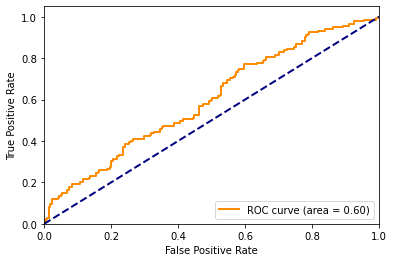

006
Accuracy = 0.5388888888888889
007
Accuracy = 0.5361111111111111
008
Accuracy = 0.5138888888888888
009
Accuracy = 0.5555555555555556
010
Accuracy = 0.5416666666666666
011
Accuracy = 0.5138888888888888
012
Accuracy = 0.6305555555555555
013
Accuracy = 0.525
015
Accuracy = 0.5583333333333333
017
Accuracy = 0.6111111111111112
018
Accuracy = 0.5138888888888888
019
Accuracy = 0.5555555555555556
020
Accuracy = 0.5416666666666666
022
Accuracy = 0.4888888888888889
023
Accuracy = 0.575
024
Accuracy = 0.5111111111111111
mean roc auc 0.5585553123969453
roc auc [0.6  0.54 0.55 0.56 0.58 0.51 0.51 0.71 0.57 0.57 0.62 0.53 0.52 0.57
 0.48 0.57 0.52]


In [10]:
#check classifier performance on imagine runs
#train on localizer, test on imagine runs 

localizer_runs = np.array([10,11,12])
imagine_runs = np.array([8,9])

for eachSubj in range(len(sub_list)):
    subNum = sub_list[eachSubj]
    print(subNum)
    
    for eachRun in range(n_runs_localizer):
        thisRun = localizer_runs[eachRun]
        thisBold = getBold(subNum,thisRun,'localizer','bilateral_oc-temp')
        
        if eachRun==0:
            trainBold = thisBold
        else:
            trainBold = np.vstack((trainBold,thisBold))

        thisLabel = getLabel(subNum,thisRun,'localizer')
        
        if eachRun==0:
            trainLabel = thisLabel
        else:
            trainLabel = np.vstack((trainLabel,thisLabel))
    trainLabel = binarize(trainLabel,'faces')
    
    for eachRun in range(n_runs_imagine):
        thisRun = imagine_runs[eachRun]
        thisBold = getBold(subNum,thisRun,'imagine','bilateral_oc-temp')
        
        if eachRun==0:
            testBold = thisBold
        else:
            testBold = np.vstack((testBold,thisBold))

        thisLabel = getLabel(subNum,thisRun,'imagine')
        
        if eachRun==0:
            testLabel = thisLabel
        else:
            testLabel = np.vstack((testLabel,thisLabel))
    testLabel = binarize(testLabel,'faces')
            
    #print('trainBold',trainBold.shape)
    #print('trainLabel',trainLabel.shape)
    #print('testBold',testBold.shape)
    #print('testLabel',testLabel.shape)
            
    score, prediction, prediction_prob = classifier(trainBold,trainLabel,testBold,testLabel,model_linReg_1,1)
    #print(prediction_prob[:5,:])

    y_true = np.ravel(testLabel)
    y_true = list(y_true)
    #print(y_true)

    y_score = prediction_prob[:,1]
    #print(y_score)

    if eachSubj == 0:
        roc_auc = calc_auc(y_true,y_score,1)
        roc_auc_all = np.array([roc_auc])
    else:
        roc_auc = calc_auc(y_true,y_score,0)
        roc_auc = np.array([roc_auc])
        roc_auc_all = np.hstack((roc_auc_all,roc_auc))

mean_roc_auc = sum(roc_auc_all)/len(sub_list)
print('mean roc auc', mean_roc_auc)
print('roc auc',roc_auc_all)

In [11]:
stats.ttest_1samp(a=roc_auc_all, popmean=0.5)

Ttest_1sampResult(statistic=4.7054776480022245, pvalue=0.00023816179679370805)

005
Accuracy = 0.5798816568047337


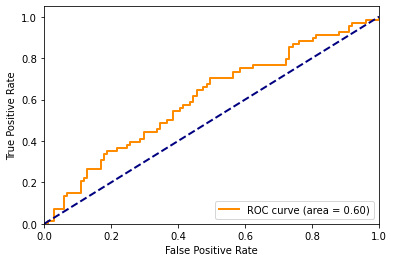

Accuracy = 0.5706806282722513


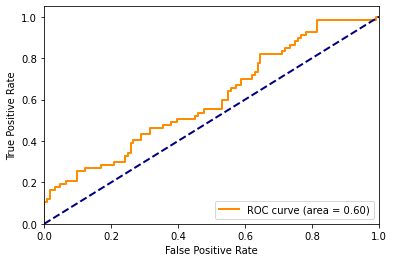

006
Accuracy = 0.5411764705882353
Accuracy = 0.531578947368421
007
Accuracy = 0.5116279069767442
Accuracy = 0.5585106382978723
008
Accuracy = 0.5595238095238095
Accuracy = 0.46875
009
Accuracy = 0.5411764705882353
Accuracy = 0.5736842105263158
010
Accuracy = 0.5297619047619048
Accuracy = 0.515625
011
Accuracy = 0.5617977528089888
Accuracy = 0.4725274725274725
012
Accuracy = 0.6081871345029239
Accuracy = 0.671957671957672
013
Accuracy = 0.5232558139534884
Accuracy = 0.526595744680851
015
Accuracy = 0.5060240963855421
Accuracy = 0.5979381443298969
017
Accuracy = 0.6402439024390244
Accuracy = 0.5816326530612245
018
Accuracy = 0.5029585798816568
Accuracy = 0.5340314136125655
020
Accuracy = 0.5705882352941176
Accuracy = 0.5421052631578948
022
Accuracy = 0.5602409638554217
Accuracy = 0.4484536082474227
023
Accuracy = 0.5828220858895705
Accuracy = 0.5786802030456852
024
Accuracy = 0.5093167701863354
Accuracy = 0.5125628140703518
mean roc auc for generalization + exceptions 0.5651798189939867


In [10]:
#check classifier performance on iagine runs
#train on localizer, test on imagine runs 
#split by g+e and baseline

localizer_runs = np.array([10,11,12])
imagine_runs = np.array([8,9])

roc_auc_all = np.zeros((len(sub_list),2))

for eachSubj in range(len(sub_list)):
    subNum = sub_list[eachSubj]
    print(subNum)
    
    for eachRun in range(n_runs_localizer):
        thisRun = localizer_runs[eachRun]
        thisBold = getBold(subNum,thisRun,'localizer','bilateral_oc-temp')
        
        if eachRun==0:
            trainBold = thisBold
        else:
            trainBold = np.vstack((trainBold,thisBold))

        thisLabel = getLabel(subNum,thisRun,'localizer')
        
        if eachRun==0:
            trainLabel = thisLabel
        else:
            trainLabel = np.vstack((trainLabel,thisLabel))
            
    trainLabel = binarize(trainLabel,'faces')
    
    for eachGr in range(2):
               
        for eachRun in range(n_runs_imagine):
            thisRun = imagine_runs[eachRun]
            thisBold = getBold(subNum,thisRun,'imagine','bilateral_oc-temp')
            #print('thisBold')
            #print(thisBold.shape)
            
            group = getGroup(subNum,thisRun)
            
            if eachGr == 0:
                thisGr = np.where(group[:] >= 3)[0]
            if eachGr == 1:
                thisGr = np.where(group[:] <= 2)[0]
            #print(thisGr)
            
            thisBold = thisBold[thisGr,:]

            if eachRun==0:
                testBold = thisBold
            else:
                testBold = np.vstack((testBold,thisBold))

            thisLabel = getLabel(subNum,thisRun,'imagine')
            thisLabel = thisLabel[thisGr]
    
            if eachRun==0:
                testLabel = thisLabel
            else:
                testLabel = np.vstack((testLabel,thisLabel))
            
        testLabel = binarize(testLabel,'faces')
        
        #print('trainBold',trainBold.shape)
        #print('trainLabel',trainLabel.shape)
        #print('testBold',testBold.shape)
        #print('testLabel',testLabel.shape)

        score, prediction, prediction_prob = classifier(trainBold,trainLabel,testBold,testLabel,model_linReg_1,1)
        #print(prediction_prob[:5,:])

        y_true = np.ravel(testLabel)
        y_true = list(y_true)
        #print(y_true)

        y_score = prediction_prob[:,1]
        #print(y_score)

        if eachSubj == 0:
            roc_auc = calc_auc(y_true,y_score,1)
            roc_auc_all[eachSubj,eachGr] = roc_auc
        else:
            roc_auc = calc_auc(y_true,y_score,0)
            roc_auc_all[eachSubj,eachGr] = roc_auc

mean_roc_auc_gr0 = sum(roc_auc_all[:,0])/len(sub_list)
mean_roc_auc_gr1 = sum(roc_auc_all[:,1])/len(sub_list)

print('mean roc auc for generalization + exceptions', mean_roc_auc_gr0)
print('roc auc',roc_auc_all[:,0])

print('mean roc auc for baseline', mean_roc_auc_gr1)
print('roc auc',roc_auc_all[:,1])

In [11]:
roc_diff = roc_auc_all[:,0] - roc_auc_all[:,1]
print(roc_diff)

stats.ttest_1samp(a=roc_diff, popmean=0)

[-0.    0.03 -0.1   0.11 -0.1   0.02  0.09 -0.05  0.   -0.19  0.03  0.02
  0.02  0.13  0.04  0.06]


Ttest_1sampResult(statistic=0.35325668795389953, pvalue=0.7288115205218813)

In [15]:
print('test against chance - after learning, g vs e')
stats.ttest_1samp(a=roc_auc_all[:,0], popmean=0.5)

test against chance - after learning, g vs e


Ttest_1sampResult(statistic=4.9461759625228865, pvalue=0.0001758092588913283)

005
[  4   5   6   7  27  28  29  30  36  37  38  39  40  50  51  52  53  54
  55  56  57  58  59  60  61  62  64  65  66  67  68  69  70  71  72  73
  74  75  77  78  79  80  85  86  87  88 107 108 109 110 111 112 113 114
 130 131 132 133 134 139 140 141 142]
[  3   4   5   6  22  23  24  25  30  31  32  33  38  39  40  41  52  53
  54  55  56  67  68  69  70  71  72  73  74  86  87  88  89  90  91  92
  93  94  95  96  97 108 109 110 111 112 113 114 115 116 121 122 123 124
 126 127 128 129 130 139 140 141 142]
Accuracy = 0.5317460317460317


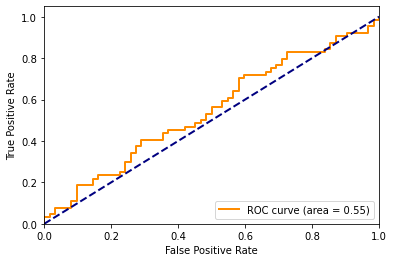

[  0   1   2   3   8   9  10  11  12  13  14  15  16  17  18  19  20  21
  22  23  24  25  26  31  32  33  34  35  41  42  43  44  45  46  47  48
  49  63  76  81  82  83  84  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 135 136 137 138 143]
[  0   1   2   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21
  26  27  28  29  34  35  36  37  42  43  44  45  46  47  48  49  50  51
  57  58  59  60  61  62  63  64  65  66  75  76  77  78  79  80  81  82
  83  84  85  98  99 100 101 102 103 104 105 106 107 117 118 119 120 125
 131 132 133 134 135 136 137 138 143]
Accuracy = 0.49382716049382713


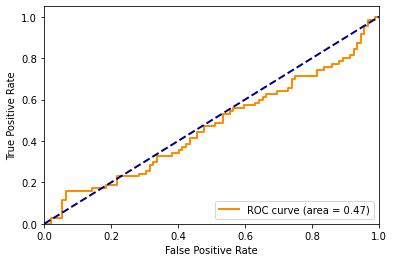

006
[  4   5   6   7   9  10  11  12  13  14  15  16  17  18  19  20  21  22
  23  38  39  40  41  51  52  53  54  56  57  58  59  65  66  67  68  73
  74  75  76  81  82  83  84  86  87  88  89  90  95  96  97  98 104 105
 106 107 108 109 110 111 120 121 122 123 134 135 136 137 138]
[  3   4   5   6   7   8   9  10  12  13  14  15  30  31  32  33  34  40
  41  42  43  44  50  51  52  53  59  60  61  62  63  64  65  66  67  68
  69  70  71  72  73  82  83  84  85  90  91  92  93  99 100 101 102 103
 112 113 114 115 131 132 133 134 139 140 141 142]
Accuracy = 0.4888888888888889
[  0   1   2   3   8  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  42  43  44  45  46  47  48  49  50  55  60  61  62  63  64  69  70
  71  72  77  78  79  80  85  91  92  93  94  99 100 101 102 103 112 113
 114 115 116 117 118 119 124 125 126 127 128 129 130 131 132 133 139 140
 141 142 143]
[  0   1   2  11  16  17  18  19  20  21  22  23  24  25  26  27  28  29
  35  36  37  38  39  45  46  47  48 

[  0   1   2   3   4   5   6   7  12  13  14  15  16  21  22  23  24  25
  48  49  50  51  52  58  59  60  61  62  63  64  65  66  67  68  69  70
  75  76  77  78  79  80  81  82  83  88  89  90  91  92 102 103 104 105
 106 107 108 109 110 116 117 118 119 120 121 122 123 124 133 134 135 136
 137 138]
Accuracy = 0.5743243243243243
013
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  31  32  33  34
  35  36  37  38  48  49  50  51  57  58  59  60  61  62  63  64  75  76
  77  78  80  81  82  83  89  90  91  92  93  98  99 100 101 102 103 104
 105 116 117 118 119 120 121 122 123 124 125 139 140 141 142]
[  4   5   6   7  16  17  18  19  35  36  37  38  39  40  41  42  44  45
  46  47  53  54  55  56  57  75  76  77  78  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 116 117 118 119 129
 130 131 132 139 140 141 142 143]
Accuracy = 0.5648854961832062
[ 14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  39
  40  41  42  43  44  45  4

Accuracy = 0.5488721804511278
[  0   1   2   3   4   5   6   7   8   9  10  11  12  18  19  20  21  22
  23  24  25  30  31  32  33  34  43  44  45  46  47  48  49  50  51  56
  57  58  59  60  61  62  63  64  65  66  67  68  69  75  76  77  78  79
  80  81  82  83  84  95  96  97  98  99 118 119 120 121 122 123 124 125
 126 139 140 141 142 143]
[  0   1   2   3   4   5   6   7   8  13  14  15  16  17  18  19  20  21
  22  54  55  56  57  58  59  60  61  62  67  68  69  70  71  72  73  74
  75  76  81  82  83  84  85  86  87  88  89  90  91  96  97  98  99 104
 105 106 107 108 109 110 111 112 121 130 131 132 133 134 135 136 137 138
 139 140 141 142 143]
Accuracy = 0.5870967741935483
024
[  4   5   6   7  17  18  19  20  27  28  29  30  31  32  33  34  35  36
  46  47  48  49  50  51  52  53  54  55  56  57  58  59  64  65  66  67
  69  70  71  72  81  82  83  84  95  96  97  98 108 109 110 111 112 113
 114 115 117 118 119 120 121 131 132 133 134 139 140 141 142]
[  0   1   2   3   4   

In [12]:
#check classifier performance on iagine runs
#train on localizer, test on imagine runs 
#split by g+e and baseline

localizer_runs = np.array([10,11,12])
imagine_runs = np.array([4,5])

roc_auc_all_before = np.zeros((len(sub_list),2))

for eachSubj in range(len(sub_list)):
    subNum = sub_list[eachSubj]
    print(subNum)
    
    for eachRun in range(n_runs_localizer):
        thisRun = localizer_runs[eachRun]
        thisBold = getBold(subNum,thisRun,'localizer','bilateral_oc-temp')
        
        if eachRun==0:
            trainBold = thisBold
        else:
            trainBold = np.vstack((trainBold,thisBold))

        thisLabel = getLabel(subNum,thisRun,'localizer')
        
        if eachRun==0:
            trainLabel = thisLabel
        else:
            trainLabel = np.vstack((trainLabel,thisLabel))
            
    trainLabel = binarize(trainLabel,'faces')
    
    for eachGr in range(2):
               
        for eachRun in range(n_runs_imagine):
            thisRun = imagine_runs[eachRun]
            thisBold = getBold(subNum,thisRun,'imagine','bilateral_oc-temp')
            #print('thisBold')
            #print(thisBold.shape)
            
            group = getGroup(subNum,thisRun)
            
            if eachGr == 0:
                thisGr = np.where(group[:] >= 3)[0]
            if eachGr == 1:
                thisGr = np.where(group[:] <= 2)[0]
            print(thisGr)
            
            thisBold = thisBold[thisGr,:]

            if eachRun==0:
                testBold = thisBold
            else:
                testBold = np.vstack((testBold,thisBold))

            thisLabel = getLabel(subNum,thisRun,'imagine')
            thisLabel = thisLabel[thisGr]
    
            if eachRun==0:
                testLabel = thisLabel
            else:
                testLabel = np.vstack((testLabel,thisLabel))
            
        testLabel = binarize(testLabel,'faces')
        
        #print('trainBold',trainBold.shape)
        #print('trainLabel',trainLabel.shape)
        #print('testBold',testBold.shape)
        #print('testLabel',testLabel.shape)

        score, prediction, prediction_prob = classifier(trainBold,trainLabel,testBold,testLabel,model_linReg_1,1)
        #print(prediction_prob[:5,:])

        y_true = np.ravel(testLabel)
        y_true = list(y_true)
        #print(y_true)

        y_score = prediction_prob[:,1]
        #print(y_score)

        if eachSubj == 0:
            roc_auc = calc_auc(y_true,y_score,1)
            roc_auc_all_before[eachSubj,eachGr] = roc_auc
        else:
            roc_auc = calc_auc(y_true,y_score,0)
            roc_auc_all_before[eachSubj,eachGr] = roc_auc

mean_roc_auc_gr0_before = sum(roc_auc_all_before[:,0])/len(sub_list)
mean_roc_auc_gr1_before = sum(roc_auc_all_before[:,1])/len(sub_list)

print('mean roc auc for generalization + exceptions before learning', mean_roc_auc_gr0_before)
print('roc auc',roc_auc_all_before[:,0])

print('mean roc auc for baseline before learning', mean_roc_auc_gr1_before)
print('roc auc',roc_auc_all_before[:,1])

In [13]:
print('test against chance - before learning, g vs e')
stats.ttest_1samp(a=roc_auc_all_before[:,0], popmean=0.5)

test against chance - before learning, g vs e


Ttest_1sampResult(statistic=0.03376205988215368, pvalue=0.9735120656695417)

In [14]:
print('test against chance - before learning, b vs b')
stats.ttest_1samp(a=roc_auc_all_before[:,1], popmean=0.5)

test against chance - before learning, b vs b


Ttest_1sampResult(statistic=0.9017092192737933, pvalue=0.3814622162170561)

In [15]:
roc_diff_before = roc_auc_all_before[:,0] - roc_auc_all_before[:,1]
print('difference in roc before learning')
print(roc_diff_before)

difference in roc before learning
[ 0.08  0.02 -0.1   0.09 -0.22 -0.12 -0.04 -0.05  0.09 -0.1  -0.01  0.05
  0.    0.1  -0.06  0.01]


In [16]:
print('before learning, is g+e different from b?')
stats.ttest_1samp(a=roc_diff_before, popmean=0)

before learning, is g+e different from b?


Ttest_1sampResult(statistic=-0.7058422138508921, pvalue=0.49110418396763833)

In [14]:
roc_learning_ge = roc_auc_all_before[:,0] - roc_auc_all[:,0]
print('is learning score different from 0 for g+e')
stats.ttest_1samp(a=roc_learning_ge, popmean=0)
#print(np.mean(roc_learning_ge))

is learning score different from 0 for g+e


Ttest_1sampResult(statistic=-3.8685766197407747, pvalue=0.001515342961136116)

In [22]:
roc_learning_b = roc_auc_all_before[:,1] - roc_auc_all[:,1]
print('is learning score different from 0 for baseline')
stats.ttest_1samp(a=roc_learning_b, popmean=0)
print(np.mean(roc_learning_b))

is learning score different from 0 for baseline
-0.04118076477627161


In [19]:
learning_diff = roc_learning_ge - roc_learning_b
print('is learning score different between g+e and baseline')
stats.ttest_1samp(a=learning_diff, popmean=0)

is learning score different between g+e and baseline


Ttest_1sampResult(statistic=-1.2669342458568496, pvalue=0.22449743965973856)

005
Accuracy = 0.5138888888888888


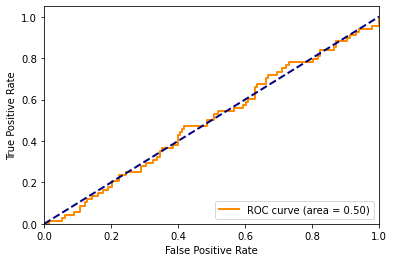

Accuracy = 0.4930555555555556
006
Accuracy = 0.5138888888888888
Accuracy = 0.5
007
Accuracy = 0.49537037037037035
Accuracy = 0.5069444444444444
008
Accuracy = 0.5370370370370371
Accuracy = 0.4444444444444444
009
Accuracy = 0.4398148148148148
Accuracy = 0.4305555555555556
010
Accuracy = 0.44907407407407407
Accuracy = 0.4097222222222222
011
Accuracy = 0.4861111111111111
Accuracy = 0.4722222222222222
012
Accuracy = 0.5231481481481481
Accuracy = 0.5347222222222222
013
Accuracy = 0.5
Accuracy = 0.4652777777777778
015
Accuracy = 0.44907407407407407
Accuracy = 0.4652777777777778
017
Accuracy = 0.49537037037037035
Accuracy = 0.4930555555555556
018
Accuracy = 0.4537037037037037
Accuracy = 0.4861111111111111
019
Accuracy = 0.5277777777777778
Accuracy = 0.5277777777777778
020
Accuracy = 0.4398148148148148
Accuracy = 0.4861111111111111
022
Accuracy = 0.47685185185185186
Accuracy = 0.5416666666666666
023
Accuracy = 0.4398148148148148
Accuracy = 0.5069444444444444
mean roc auc 0.48314004992054266


In [21]:
#check classifier performance on iagine runs
#train on 1 imagine run, test on other imagine run

folds = np.array([[8,9],[9,8]])

for eachSubj in range(len(sub_list)):
    subNum = sub_list[eachSubj]
    print(subNum)
       
    for eachFold in range(2):
        
        trainRun = folds[eachFold, 0]
        
        trainBold = getBold(subNum,trainRun,'imagine','bilateral_hippo')
        
        trainLabel = getLabel(subNum,trainRun,'imagine')
        trainLabel = binarize(trainLabel,'faces')
        
        testRun = folds[eachFold, 1]
        
        testBold = getBold(subNum,testRun,'imagine','bilateral_hippo')
        
        testLabel = getLabel(subNum,testRun,'imagine')
        testLabel = binarize(testLabel,'faces')
        
        #print('trainBold',trainBold.shape)
        #print('trainLabel',trainLabel.shape)
        #print('testBold',testBold.shape)
        #print('testLabel',testLabel.shape)
        
        score, prediction, prediction_prob = classifier(trainBold,trainLabel,testBold,testLabel,model_linReg_1,1)
        #print(prediction_prob[:5,:])

        y_true = np.ravel(testLabel)
        y_true = list(y_true)
        #print(y_true)

        y_score = prediction_prob[:,1]
        #print(y_score)
        
        if eachSubj == 0 and eachFold == 0:
            roc_auc = calc_auc(y_true,y_score,1)
            roc_auc_sum = roc_auc
        else:
            roc_auc = calc_auc(y_true,y_score,0)
            roc_auc_sum = roc_auc_sum + roc_auc

mean_roc_auc = roc_auc_sum/(2*len(sub_list))
print('mean roc auc', mean_roc_auc)